In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split as tts

In [2]:
class DeepNeuralNetwork:
    
    def __init__(self, layers, activations_names, loss):
        assert(len(layers) == len(activations))
        self.layers = layers
        self.relu = lambda x: (x > 0) * x
        self.relu_derivative = lambda x: (x > 0) * 1
        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.sigmoid_derivative = lambda x: self.sigmoid(x) * (1 - self.sigmoid(x))
        self.tanh = lambda x: np.tanh(x)
        self.tanh_derivative = lambda x: 1 - np.power(np.tanh(x), 2)
        self.linear = lambda x: x
        self.linear_derivative = lambda x: np.ones(x.shape)
        self.softmax = lambda x: np.exp(x) / sum(np.exp(x))
        self.activations, self.derivatives = self.__string_to_function(activations_names)
        mean_squared_error = lambda Y_pred, Y, m: (1/m) * ((Y - Y_pred) ** 2).sum()
        binary_cross_entropy = lambda Y_pred, Y, m: (-1/m) * (Y*np.log(Y_pred) + (1-Y)*np.log(1-Y_pred)).sum()
        self.loss = eval(loss)
        self.weights = None
        self.L = len(layers)
        self.losses = []
    
    def __forward_propagation(self, X):
        cache = {}
        m = X.shape[1]
        cache["Z1"] = np.dot(self.weights["W1"], X) + self.weights["b1"]
        cache["A1"] = self.activations[0](cache["Z1"])
        for l in range(1, self.L):
            next_W = self.weights["W" + str(l + 1)]
            next_b = self.weights["b" + str(l + 1)]
            prev_A = cache["A" + str(l)]
            next_Z = np.dot(next_W, prev_A) + next_b
            next_A = self.activations[l](next_Z)
            cache["Z" + str(l + 1)] = next_Z
            cache["A" + str(l + 1)] = next_A
        AL = cache["A" + str(self.L)]
        return AL, cache
    
    def __backward_propagation(self, X, Y, cache):
        gradients = {}
        m = X.shape[1]
        dZL = cache["A" + str(self.L)] - Y
        dWL = (1/m) * np.dot(dZL, cache["A" + str(self.L - 1)].T)
        dbL = (1/m) * np.sum(dZL, axis=1, keepdims=True)
        gradients["dZ" + str(self.L)] = dZL
        gradients["dW" + str(self.L)] = dWL
        gradients["db" + str(self.L)] = dbL
        for l in reversed(range(2, self.L + 1)):
            current_W = self.weights["W" + str(l)]
            current_dZ = gradients["dZ" + str(l)]
            prev_Z = cache["Z" + str(l - 1)]
            if l == 2:
                prev_prev_A = X
            else : prev_prev_A = cache["A" + str(l - 2)]
            prev_dZ = np.dot(current_W.T, current_dZ) * self.derivatives["d" + str(l - 1)](prev_Z)
            prev_dW = np.dot(prev_dZ, prev_prev_A.T)
            prev_db = (1/m) * np.sum(prev_dZ)
            gradients["dZ" + str(l - 1)] = prev_dZ
            gradients["dW" + str(l - 1)] = prev_dW
            gradients["db" + str(l - 1)] = prev_db
        return gradients
    
    def __string_to_function(self, activations_names):
        activations_ = []
        derivatives_ = {}
        for i, act_name in enumerate(activations_names):
            activations_.append(eval('self.' + act_name))
            derivatives_["d" + str(i + 1)] = eval('self.' + act_name + '_derivative')
        derivatives_.popitem()
        return activations_, derivatives_
    
    def __initialize_weights(self, input_size):
        weights = {}
        L = len(self.layers)
        weights["W1"] = np.random.randn(self.layers[0], input_size)
        weights["b1"] = np.zeros((self.layers[0], 1))
        for l in range(1, L):
            weights["W" + str(l + 1)] = np.random.randn(self.layers[l], self.layers[l - 1])
            weights["b" + str(l + 1)] = np.zeros((self.layers[l], 1))
        return weights
    
    def __update_weights(self, gradients, learning_rate):
        for l in range(1, self.L + 1):
            self.weights["W" + str(l)] -= learning_rate * gradients["dW" + str(l)]
            self.weights["b" + str(l)] -= learning_rate * gradients["db" + str(l)]
    
    def train(self, X, Y, epochs, learning_rate, print_each=100):
        m = X.shape[1] # X is a (features, m) array
        input_size = X.shape[0] # (features)
        self.weights = self.__initialize_weights(input_size)
        for i in range(epochs):
            AL, cache = self.__forward_propagation(X)
            cost = self.loss(AL, Y, m)
            self.losses.append(cost)
            gradients = self.__backward_propagation(X, Y, cache)
            self.__update_weights(gradients, learning_rate)
            if (i % print_each == 0) : print("Epoch", i, "Loss", cost)
                
    def predict(self, X):
        Y_pre, cache = self.__forward_propagation(X)
        return Y_pre.T

In [3]:
def upload_images(folder_path, img_size=(64, 64)):
  images = []
  imgs_names = os.listdir(folder_path)
  for img_name in imgs_names:
    img_path = os.path.join(folder_path, img_name)
    img = Image.open(img_path).convert('L').resize(img_size)
    img = np.array(img).reshape(np.prod(img_size))
    images.append(img)
  assert(len(images) == len(imgs_names))
  return np.array(images)

In [4]:
img_size = (64, 64)
tumor_images = upload_images('brainDataset/yes')
tumor_labels = np.ones((len(tumor_images), 1))
no_tumor_images = upload_images('brainDataset/no')
no_tumor_labels = np.zeros((len(no_tumor_images), 1))
tumor_images.shape, tumor_labels.shape, no_tumor_images.shape, no_tumor_labels.shape

((1500, 4096), (1500, 1), (1500, 4096), (1500, 1))

In [5]:
images = np.concatenate((no_tumor_images, tumor_images), axis=0)
labels = np.concatenate((no_tumor_labels, tumor_labels), axis=0)
images.shape, labels.shape

((3000, 4096), (3000, 1))

In [6]:
X_train, X_test, Y_train, Y_test = tts(images, labels, test_size=0.2, shuffle=True)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((2400, 4096), (2400, 1), (600, 4096), (600, 1))

In [7]:
def preprocess(X, Y):
  X_norm = X / 255
  return X_norm.T, Y.T

In [8]:
X_train, Y_train = preprocess(X_train, Y_train)
X_train.shape, Y_train.shape

((4096, 2400), (1, 2400))

In [9]:
layers = [100, 50, 10, 1]
activations = ["tanh", "tanh", "tanh", "sigmoid"]
dnn_model = DeepNeuralNetwork(layers, activations, loss='binary_cross_entropy')
dnn_model.train(X_train, Y_train, epochs=401, learning_rate=0.00085, print_each=100)

Epoch 0 Loss 1.233771746624706
Epoch 100 Loss 0.22572196430466285
Epoch 200 Loss 0.15613633747415184
Epoch 300 Loss 0.3571602844488726
Epoch 400 Loss 0.1095786481337359


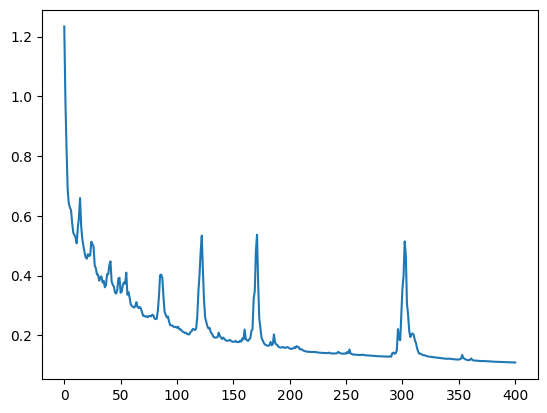

In [10]:
losses = dnn_model.losses
epochs = list(range(401))
plt.plot(epochs, losses)
plt.show()

In [11]:
def pick_random_images(folder_one, folder_two, size=10):
  imgs_names_one = os.listdir(folder_one)
  imgs_names_two = os.listdir(folder_two)
  imgs_paths_one = [os.path.join(folder_one, img_name) for img_name in imgs_names_one]
  imgs_paths_two = [os.path.join(folder_two, img_name) for img_name in imgs_names_two]
  imgs_paths = imgs_paths_one + imgs_paths_two
  np.random.shuffle(imgs_paths)
  return np.random.choice(imgs_paths, size)

In [12]:
def show_prediction(model, img_paths, img_show_size=(64, 64)):
  num_images = len(img_paths)
  fig, axs = plt.subplots(1, num_images, figsize=(12, 4))
  for i in range(num_images):
    img = Image.open(img_paths[i]).convert('L')
    img_norm = np.array(img.resize((64, 64))).reshape(64*64, 1) / 255
    pred = model.predict(img_norm)[0][0]
    pred = 'Tumor' if pred > 0.5 else 'No Tumor'
    to_show_img = np.array(img.resize(img_show_size))
    axs[i].imshow(to_show_img, cmap='gray')
    axs[i].set_title(pred)
    axs[i].axis('off')
  plt.show()

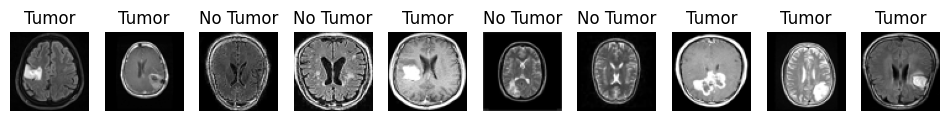

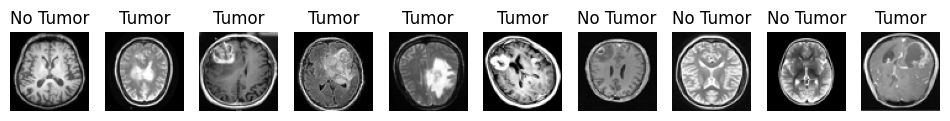

In [13]:
random_imgs_test_1 = pick_random_images('brainDataset/no', 'brainDataset/yes')
random_imgs_test_2 = pick_random_images('brainDataset/no', 'brainDataset/yes')
show_prediction(dnn_model, random_imgs_test_1, img_show_size=(64, 64))
show_prediction(dnn_model, random_imgs_test_2, img_show_size=(64, 64))